# Spatialization of hail detection

## A.Imports

In [5]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

In [2]:
! git clone https://github.com/nanopiero/spatialisation_grele
sys.path.append('spatialisation_grele')

Cloning into 'spatialisation_grele'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 42 (delta 24), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (42/42), 393.87 KiB | 3.86 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [3]:
from utils import HailDataset, plot_images_and_reports

## B. Terms of the machine learning problem

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


In [40]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
30/06/2024
@author: lepetit
"""
from random import randint
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import copy
from numba import jit, float32
from numpy.random import randint

####################################################
########## generation on the fly with JIT ##########
####################################################
use_jitc = True

@jit(nopython=use_jitc, cache=True)
def pseudo_meshgrid(size):
  b = np.arange(0, size).repeat(size).reshape(1,size,size)
  a = np.transpose(b, (0,2,1))
  return  a.astype(np.float32), b.astype(np.float32)

@jit(nopython=use_jitc, cache=True)
def generate_cell_and_hail_characteristics(nsteps, size, pseudo_size, centered,
                                           relative_advection_speed,
                                           smajor_axis_k=None,
                                           eccentricity_k=None,
                                           theta_increment=None,
                                           intensity=None
                                           ):
    # Choose k
    if centered:
      k = np.random.randint(nsteps//3, nsteps-nsteps//3)
    else:
      k = np.random.randint(1, nsteps-1)

    # Generate the kth major_axis, minor_axis,  center, rotation, focus, and radius
    if smajor_axis_k is None:
      smajor_axis_k = float32(np.random.uniform(5, 20))

    if centered:
      center_k = np.array([size // 2, size //2 ]).astype(np.float32)
    else:
      ray_max = (pseudo_size - 3*smajor_axis_k) // 2
      center_k = np.array([size // 2, size //2 ]) + (2*np.random.random(2) - 1) * ray_max
      center_k = center_k.astype(np.float32)

    if eccentricity_k is None:
      eccentricity_k = float32(0.2 + 0.8 * np.random.rand())

    theta_k = float32(np.pi * np.random.rand())

    # Generate advection speed and radius increment
    if centered:
      relative_advection_speed = 2*np.random.normal(0, 3, 2).astype(np.float32)
      advection_speed = np.zeros(2).astype(np.float32)
    else:
      advection_speed = (2*np.random.normal(0, 3, 2) - relative_advection_speed).astype(np.float32)

    smajor_axis_increment = float32(np.random.normal(0, 1/nsteps))
    eccentricity_increment = float32(2/nsteps * np.random.rand())

    if theta_increment is None:
      theta_increment = float32(np.random.normal(0, np.pi/nsteps))

    # Fill centers and radii arrays
    arange_nsteps = np.arange(nsteps).astype(np.float32)
    abs_centers = center_k[0] + (arange_nsteps - k) * advection_speed[0]
    ord_centers = center_k[1] + (arange_nsteps - k) * advection_speed[1]

    smajor_axis = smajor_axis_k + (arange_nsteps - k) * smajor_axis_increment
    smajor_axis[smajor_axis <= 0] = 0.
    eccentricity = eccentricity_k  +  (arange_nsteps - k) * eccentricity_increment
    eccentricity[eccentricity <= 0] = -1*eccentricity[eccentricity <= 0]
    eccentricity[eccentricity >= 0.9] = 0.9
    theta = theta_k  +  (arange_nsteps - k) * theta_increment
    # Get intensity of the cell and hail characteristics:
    ratio_radius = float32(0.3)
    if intensity is None:
      intensity = float32(np.random.uniform(0.3,0.8))

    radius = ratio_radius * eccentricity * smajor_axis
    hail_steps = (intensity > 0.5) * (theta_increment <= 0) * (radius > 2) * (radius < 4)
    hail_size = float32(10/(size**2) * np.pi) * smajor_axis**2 * np.sqrt(1 - eccentricity**2) # hail size prop to the area

    return abs_centers, ord_centers, smajor_axis, eccentricity, \
           theta, theta_increment, intensity, hail_steps, hail_size, radius


@jit(nopython=use_jitc, cache=True)
def closest_nonzero_index(x: np.array) -> int:
    # Ensure x is a 1D tensor

    D = x.shape[0]
    mid_index = D // 2

    # Find all non-zero indices
    nonzero_indices = np.nonzero(x)[0]

    # If there are no non-zero elements, return -1 or handle as needed
    if len(nonzero_indices) == 0:
        return -1

    # Find the non-zero index closest to D//2
    distances = np.abs(nonzero_indices - mid_index)
    closest_index = nonzero_indices[np.argmin(distances)].item()
    return closest_index


@jit(nopython=use_jitc, cache=True)
def select_random_nonzero_pixel(x):
    # Find all non-zero indices
    non_zero_indices = np.argwhere(x != 0)

    # Select a random index from the non-zero indices
    random_index = non_zero_indices[np.random.randint(len(non_zero_indices))]

    return random_index

@jit(nopython=use_jitc, cache=True)
def ground_truth_to_reports(two_circles, centered, freq_reports, toss=False):
  if centered and toss: # at least one report
    when_hail = np.sum(two_circles.reshape(two_circles.shape[0],-1), axis=1)  > 0
    where_report = closest_nonzero_index(when_hail)
    random_index = select_random_nonzero_pixel(two_circles[where_report])
    value = two_circles[where_report, random_index[0], random_index[1]].item()


  thresh = 0.
  reports = np.random.binomial(1, freq_reports, two_circles.shape).astype(np.float32)
  reports *= two_circles
  # print('sum reports', reports.sum())

  if centered and toss:
    two_circles[where_report, random_index[0], random_index[1]] = value

  return reports.sum(axis=0)


@jit(nopython=use_jitc, cache=True)
def simu_moving_ellipse(image, reports, a, b,
                        pseudo_size,
                        stratification=None,
                        centered=False, relative_advection_speed=np.zeros(2),
                        add_target=True,
                        freq_occurrence=0.5,
                        freq_reports=0.5):

  nsteps, size, _ = image.shape
  toss = False

  if stratification is None:
    abs_centers, ord_centers, smajor_axis, eccentricity, \
      theta, theta_increment, intensity, hail_steps, hail_size, radius = \
      generate_cell_and_hail_characteristics(nsteps, size, pseudo_size, centered, relative_advection_speed)
    hail_steps_sum = hail_steps.sum()

  elif stratification == 'occurrence':
    toss = (np.random.rand(1) < freq_occurrence).item()
    if toss:
      ratio_radius = float32(0.3)
      hail_step_k = False
      while not hail_step_k:
        smajor_axis_k = float32(np.random.uniform(5, 20))
        eccentricity_k = float32(0.2 + 0.7 * np.random.rand())  # not beyond 0.9
        enhancer_hail_k = ratio_radius * eccentricity_k * smajor_axis_k
        hail_step_k = (enhancer_hail_k < 4) * (enhancer_hail_k > 2)
      theta_increment = - float32(np.abs(np.random.normal(0, np.pi/nsteps)))
      intensity = float32(np.random.uniform(0.5, 0.8))

      abs_centers, ord_centers, smajor_axis, eccentricity, \
        theta, theta_increment, intensity, hail_steps, hail_size, radius = \
        generate_cell_and_hail_characteristics(nsteps, size, pseudo_size, centered,
                                               relative_advection_speed,
                                               smajor_axis_k=smajor_axis_k,
                                               eccentricity_k=eccentricity_k,
                                               theta_increment=theta_increment,
                                               intensity=intensity
                                               )
      # print(toss, ' steps :', hail_steps, ' sizes :', hail_size, 'theta inc', theta_increment, 'intensity', intensity, 'radius', radius)
      hail_steps_sum = hail_steps.sum()

    else:
      hail_steps_sum = 1.
      while hail_steps_sum != 0.:
        abs_centers, ord_centers, smajor_axis, eccentricity, \
          theta, theta_increment, intensity, hail_steps, hail_size, radius = \
          generate_cell_and_hail_characteristics(nsteps, size, pseudo_size, centered,
                                                relative_advection_speed)
        hail_steps_sum = hail_steps.sum()




  elif stratification == 'size':
    pass
  # Make the cells:
  delta_abs_interfocus = eccentricity * smajor_axis * np.cos(theta)
  delta_ord_interfocus = eccentricity * smajor_axis * np.sin(theta)

  abs_focus1 = abs_centers + delta_abs_interfocus
  ord_focus1 = ord_centers + delta_ord_interfocus
  abs_focus2 = abs_centers - delta_abs_interfocus
  ord_focus2 = ord_centers - delta_ord_interfocus

  square_distances_to_focus1 = (a - abs_focus1.reshape((nsteps, 1, 1)))**2 + \
                         (b - ord_focus1.reshape((nsteps, 1, 1)))**2
  square_distances_to_focus2 = (a - abs_focus2.reshape((nsteps, 1, 1)))**2 + \
                         (b - ord_focus2.reshape((nsteps, 1, 1)))**2

  sum_distances = np.sqrt(square_distances_to_focus1) + np.sqrt(square_distances_to_focus2)
  ellipses =  1. * (sum_distances < 1.25*2*smajor_axis.reshape(nsteps, 1, 1))

  # apply a random intensity
  ellipses *= intensity

  # Update image
  image += ellipses

  # Make ground truth
  if hail_steps_sum > 0 and add_target:

    radius = radius.reshape((nsteps, 1, 1))
    den = 1/radius**2
    two_circles = (radius**2 - square_distances_to_focus1) * den * (square_distances_to_focus1 < radius**2) \
               + (radius**2 - square_distances_to_focus2) * den * (square_distances_to_focus2 < radius**2)
    two_circles *= hail_steps.reshape((nsteps, 1, 1))
    # print('add_target and max ', add_target, two_circles.max())
    # hail size prop to the area :
    two_circles *= hail_size.reshape((nsteps, 1, 1))
    reports += ground_truth_to_reports(two_circles, centered, freq_reports, toss)


  return image, reports, relative_advection_speed


@jit(nopython=use_jitc, cache=True)
def spatialized_gt(ndiscs=5, size=64, pseudo_size=None,
                   nsteps=60, stratification=None,
                   centered=False, freq_occurrence=0.5,
                  freq_reports=0.5):

  if pseudo_size is None:
    pseudo_size = size

  image = np.zeros((nsteps, size, size)).astype(np.float32)
  reports = np.zeros((1, size, size)).astype(np.float32)
  a, b = pseudo_meshgrid(size)

  if centered:
    image, reports, relative_advection_speed0 = simu_moving_ellipse(image, reports, a, b,
                                                           pseudo_size,
                                                           stratification,
                                                           centered=True,
                                                           freq_occurrence=freq_occurrence,
                                                           freq_reports=freq_reports
                                                           )
    for i in range(ndiscs - 1):
      image, reports, _ = simu_moving_ellipse(image, reports, a, b,
                                     pseudo_size,
                                     centered=False,
                                     relative_advection_speed=relative_advection_speed0,
                                     add_target=False)
  else:
    image, reports, relative_advection_speed0 = simu_moving_ellipse(image, reports, a, b,
                                                           pseudo_size,
                                                           stratification="occurrence",
                                                           centered=False,
                                                           freq_occurrence=freq_occurrence,
                                                           freq_reports=freq_reports
                                                           )
    for i in range(ndiscs - 1):
      image, reports, _ = simu_moving_ellipse(image, reports, a, b,
                                              pseudo_size,
                                              stratification,
                                              freq_occurrence=freq_occurrence,
                                              freq_reports=freq_reports)
  return image, reports





##############################
########## Datasets ##########
##############################

from torch.utils.data import Dataset

class HailDataset(Dataset):
    def __init__(self, length_dataset=6400, centered=True, freq_reports=0.01):
        """
        Args:
              I need a pytorch dataset that will simply embed two numpy function that generates random tensors.
              These functions, called spatialized_gt and create_cmls_filter are @jit decorated.
        """
        self.length_dataset = length_dataset
        self.centered = centered
        self.ndiscs = 4
        self.pseudo_size = 172
        self.nsteps = 6
        self.freq_reports= freq_reports

        if centered:
          self.stratification ='occurrence'
          self.size_image = 64
        else:
          self.stratification = None
          self.size_image = 172


    def __len__(self):
        return self.length_dataset

    def __getitem__(self, idx):
        image, reports = spatialized_gt(ndiscs=self.ndiscs,
                               size=self.size_image,
                               pseudo_size=self.pseudo_size,
                               nsteps=self.nsteps,
                               stratification=self.stratification,
                               centered=self.centered,
                               freq_reports=self.freq_reports
                               )
        image = torch.tensor(image)
        reports = torch.tensor(reports)

        return image, reports



###################################
########## Vizualisation ##########
###################################

import matplotlib.gridspec as gridspec

def plot_images(images, ground_truth, reports):
    # Set up the figure with GridSpec
    fig = plt.figure(figsize=(18, 20))
    gs = gridspec.GridSpec(6, 5, width_ratios=[1, 1, 1, 1, 2])  # Last column twice as wide

    # Manually create axes array for uniform handling as before
    axs = [fig.add_subplot(gs[i, j]) for i in range(6) for j in range(5)]

    # Hide all primary spines and ticks
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(axis='both', which='both', left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)

    # Image and noisy image plots
    for i in range(3):
        image_indices = [4*i, 4*i+1, 4*i+2, 4*i+3]
        for j in range(4):
            ax = axs[2*i*5 + j]
            img = images[image_indices[j]]
            # img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img) + 0.000001)
            ax.imshow(img, cmap='gray', aspect=1, vmin=0, vmax=1)
            ax.axis('off')
            ax = axs[(2*i + 1)*5  + j]
            img = ground_truth[image_indices[j]]
            # img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img) + 0.000001)
            ax.imshow(img, cmap='gray', aspect=1, vmin=0, vmax=1)
            ax.axis('off')

    plt.tight_layout()
    plt.show()



def plot_image_and_reports(image, reports, mode_plot_reports='occurrence'):
    # Set up the figure with GridSpec
    fig = plt.figure(figsize=(18, 20))
    gs = gridspec.GridSpec(1, 7, width_ratios=[1, 1, 1, 1, 1,1,1])  # Last column twice as wide

    # Manually create axes array for uniform handling as before
    axs = [fig.add_subplot(gs[i]) for i in range(7)]

    # Hide all primary spines and ticks
    for ax in axs:
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.tick_params(axis='both', which='both', left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)

    # Image and noisy image plots
    for i in range(6):
      ax = axs[i]
      img = image[i]
      ax.imshow(img, cmap='gray', aspect=1, vmin=0, vmax=1)
      ax.axis('off')
    ax = axs[-1]
    img = reports[0]
    if mode_plot_reports =='occurrence':
      ax.imshow(img, cmap='gray', aspect=1, vmin=0, vmax=0.00001)
    else:
      # 20 cm
      ax.imshow(img, cmap='gray', aspect=1, vmin=0, vmax=0.2)

    ax.axis('off')


    plt.tight_layout()
    plt.show()

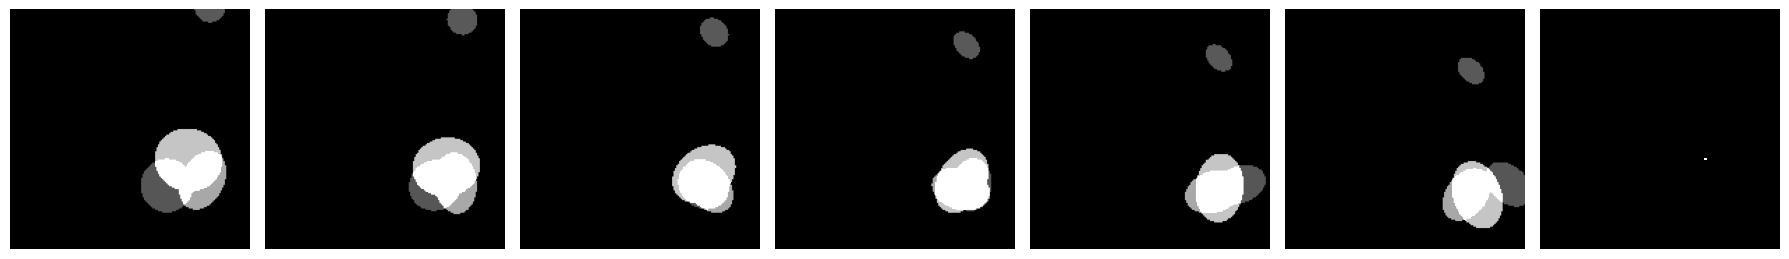

In [493]:
S = 172
# in the dataset :
# image = spatialized_gt(ndiscs=4, size=S, nsteps=12)
image, reports = spatialized_gt(ndiscs=4, size=64, pseudo_size=172, nsteps=6, stratification='occurrence', centered=True, freq_reports=0.01)
image, reports = spatialized_gt(ndiscs=4, size=172, pseudo_size=172, nsteps=6, stratification=None, centered=False, freq_reports=0.01)
device = torch.device('cpu')
image = torch.tensor(image).float().to(device)
plot_image_and_reports(image, reports)

In [36]:
%%timeit -n 5 -r 1
for _ in range(6400):
  image, reports = spatialized_gt(ndiscs=4, size=64, pseudo_size=172, nsteps=6, stratification='occurrence', centered=True, freq_reports=0.01)

18.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


In [37]:
%%timeit -n 1 -r 1
for _ in range(6400):
  image, reports = spatialized_gt(ndiscs=4, size=172, pseudo_size=172, nsteps=6, stratification=None, centered=False, freq_reports=0.01)

2min 50s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The main tool is the PyTorch customized dataset `HailDataset()`. `HailDataset()` generates on the fly six consecutive pseudo-radar images  and hail reports.

The consecutive pseudo-radar images contain elliptic rain cells. They are stored in 6-channel torch arrays of size `6 x S x S` (e.g., the torch array **images** below). The reports are the non-zero values (hail size in *m.*) stored in one array of size `S x S` (the torch array **reports**).

`HailDataset` has two options:

1. **To get small (S=64) images centered on a moving cell, pass:**

   ```python
   HailDataset(centered=True)
   ```

   In this case, the reports are related to the cell that lies in the center of the images. Please note that when there is no report (i.e., `reports == 0` on every pixel for every channel), the center cell didn't yield hail for sure. There could be other cells on the pseudo-radar images, and those cells possibly yield hail. However, there is no report coming from those cells in the array **reports**.

2. **To get larger images (S=172) that are not centered, pass:**

   ```python
   HailDataset(centered=False)
   ```

   In this case, the reports could be related to any of the hailing cells.

In [7]:
# Example with centered images:
haildataset = HailDataset(centered=True)
batch_size = 64
num_workers = 2

# Compilation will take about 1 min
dataloader = DataLoader(haildataset, batch_size=batch_size, num_workers=num_workers)
images, reports = next(iter(dataloader))

In [9]:
%%timeit -n 1 -r 1
# test browse the dataset for one epoch (100 mini-batches of size 64)
for i, (images, reports) in enumerate(dataloader):
  pass

12.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


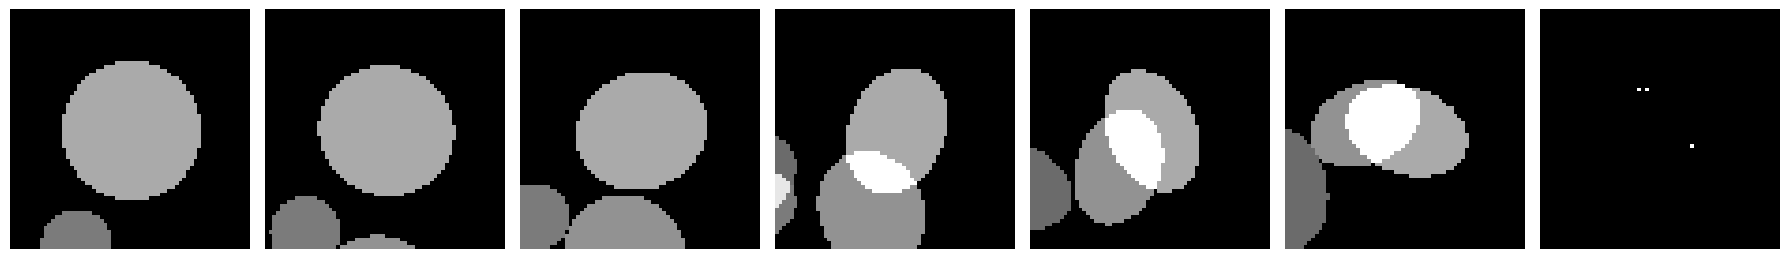

In [21]:
# plot 6 consectutive pseudo-radar images and related reports from the k th element of the mini-batch
k = 11
img = torch.tensor(images[k,...])
rpt = torch.tensor(reports[k,...])
plot_images_and_reports(img, rpt)

In [23]:
# Example with centered=False:
haildataset = HailDataset(centered=False)
dataloader = DataLoader(haildataset, batch_size=batch_size, num_workers=num_workers)
images, reports = next(iter(dataloader))

In [24]:
%%timeit -n 1 -r 1
# test browse the dataset for one epoch (100 mini-batches of size 64)
for i, (images, reports) in enumerate(dataloader):
  pass

1min 30s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


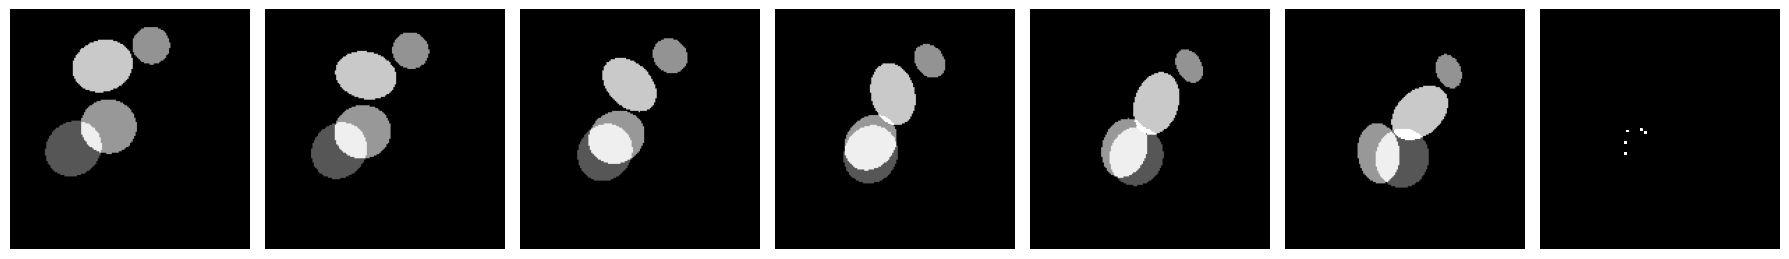

In [25]:
k = 11
img = torch.tensor(images[k,...])
rpt = torch.tensor(reports[k,...])
plot_images_and_reports(img, rpt)